# DDPM on MNIST

This repository is an small implementation of the pseudo algorithm of [Ho et al.](https=//arxiv.org/abs/2006.11239) as shown in the following image: ![image](images/ddpm_pseudocode.jpg)
Other helpful resource is the one of [Luo](https://arxiv.org/abs/2208.11970).

Learning: Most other implementations just destroy collapse/failed predictions with heavy overparametrization (unet_base makes good results with 10M params, but bad ones with 1M, probably interchanging groupnorm with instance norm or at least increasing the amount of groups would probably make stuff better). Mine now works kind of okay with less than 1M, but some "difficult" numbers (2,3,5) are still missing.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Device: cuda:0
xt_max = 4.571, xt_min = -3.400, xt_mean =  -0.001
x0_max = 2.821, x0_min = -0.424, x0_mean =  -0.003


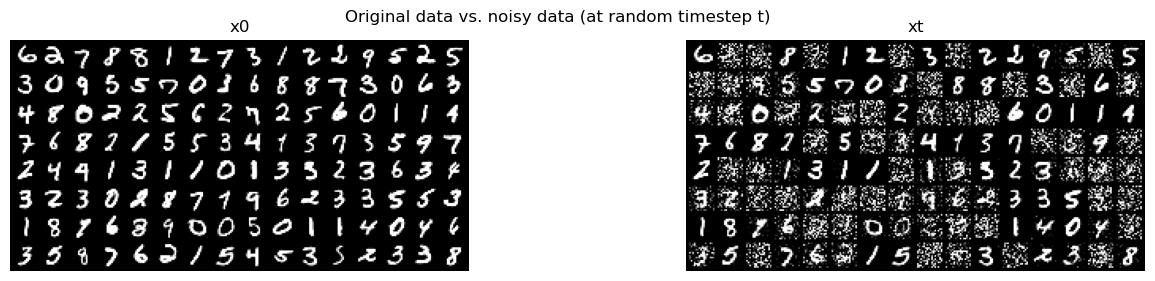

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

BATCH_SIZE    = 128 # Matters alot! Small model, small problem --> small batchsize!
IMG_SIZE      = 16
INITIAL_LAYER = 32 # Matters alot! 32 okay, 48 failed, 64 best
LEARNING_RATE = 2e-4 # shouldnt matter too much as using RAdam/AdamW
SCHEDULE      = "cosine" # matters alot!
# NOTE: MOST CRUCIAL: Batch norm --> mode collapse, Instance norm () --> perfectly working, even on small batch size.
# Using upscale instead of convetranspose matters!
# Minimal latent dimension matters! (in unet_mine)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

def plot_noisy_pair(x0, xt):

    grid_x0 = make_grid(x0, nrow=16)
    grid_xt = make_grid(xt, nrow=16)

    fig, axes = plt.subplots(1, 2, figsize=(16, 3))

    axes[0].imshow(grid_x0.permute(1, 2, 0).cpu())
    axes[0].set_title('x0')
    axes[0].axis('off')

    axes[1].imshow(grid_xt.permute(1, 2, 0).cpu())
    axes[1].set_title('xt')
    axes[1].axis('off')

    plt.suptitle("Original data vs. noisy data (at random timestep t)")
    plt.show()

    return

transform = torchvision.transforms.transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_dataset = torchvision.datasets.MNIST('./../data', train=True, transform=transform, download=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = torchvision.datasets.MNIST('./../data', train=False, transform=transform, download=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

T = 1000

def linear_schedule(T, start=1e-4, end=0.02):
    beta_schedule = torch.linspace(start=start, end=end, steps=T)
    alpha_schedule = 1 - beta_schedule
    alpha_cumprod = alpha_schedule.cumprod(dim=0)
    return beta_schedule, alpha_schedule, alpha_cumprod

def cosine_beta_schedule(T, s=0.008):
    """Cosine schedule from annotated transformers."""
    steps = T + 1
    x = torch.linspace(0, T, steps)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    beta_schedule = torch.clip(betas, 0.0001, 0.9999)
    alpha_schedule = 1-beta_schedule
    return beta_schedule, alpha_schedule, alphas_cumprod[1:]

# Crucially better performance against linear
beta_schedule, alpha_schedule, alpha_cumprod = cosine_beta_schedule(T) if SCHEDULE == "cosine" else linear_schedule(T)

def preprocess(x0): 

    # Noise creation equivalent to DDPMs
    t = torch.randint(low=0, high=T, size=(x0.shape[0],))
    noise = torch.randn_like(x0)
    alpha = alpha_cumprod[t]
    xt = x0.clone()
    for j in range(xt.shape[0]):
        xt[j] = torch.sqrt(alpha[j]) * xt[j] + (1-alpha[j]) * noise[j] # in terms of x0

    return xt,t,noise, alpha

(x0, label) = next(iter(train_dataloader))
xt,t,noise,alpha = preprocess(x0)

print(f"xt_max = {xt.max():.3f}, xt_min = {xt.min():.3f}, xt_mean =  {xt.mean():.3f}")
print(f"x0_max = {x0.max():.3f}, x0_min = {x0.min():.3f}, x0_mean =  {x0.mean():.3f}")

plot_noisy_pair(x0, xt)

### Model Definition

We can choose from different Unets. Unet mine is my design (focus on simplicity only), the other ones are from other people.

In [2]:
from unet_mine import Unet
model = Unet(n_channels=1, t_emb_dim=128, img_size=IMG_SIZE, initial_layer=INITIAL_LAYER)

# from unet_minimal import Unet
# model = Unet(timesteps=1000, time_embedding_dim=128, in_channels=1, out_channels=1, base_dim=32)

# from unet_base import Unet
# model = Unet({     
#     "im_channels" : 1,
#     "im_size" : 16,
#     "down_channels" : [32, 64, 128, 256],
#     "mid_channels" : [256, 256, 128],
#     "down_sample" : [True, True, False],
#     "time_emb_dim" : 128,
#     "num_down_layers" : 2,
#     "num_mid_layers" : 2,
#     "num_up_layers" : 2,
#     "num_heads" : 4
# })

model.to(device)

batch,_ = next(iter(train_dataloader)) 
xt,t,noise,alpha = preprocess(batch)
xt,t,noise = xt.to(device), t.to(device), noise.to(device)
out_sample = model(xt,t)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters.")

Model has 873121 parameters.


/home/fe/goettlich/miniconda3/envs/mlp/lib/python3.11/site-packages/torch/nn/modules/instancenorm.py:88: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


In [3]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
mse = torch.nn.MSELoss()

def train_one_epoch(epoch_number):

    model.train()
    running_loss = 0.0

    num_accumulated_losses = len(train_dataloader)//10

    for i, (batch, label) in enumerate(train_dataloader):

        if i >= (num_accumulated_losses)*10:
            break
        optimizer.zero_grad()

        xt,t,noise,alpha = preprocess(batch)
        xt,t,noise = xt.to(device), t.to(device), noise.to(device)

        # predict noise, given (xt[B,1,W,H],t[B])
        predicted_noise = model(xt,t)
        loss = mse(noise, predicted_noise)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()

        if i%num_accumulated_losses == num_accumulated_losses - 1:

            last_loss = running_loss / num_accumulated_losses
            print(f"Epoch: {epoch_number+1}, iteration: [{i +1} / {len(train_dataloader)}], loss: {running_loss/num_accumulated_losses:.5f}")
            running_loss = 0.0

    return last_loss

def validate():
    # Disable gradient computation and reduce memory consumption.
    model.eval()
    with torch.no_grad():
        running_vloss = 0.0
        for vdata in val_dataloader:
            batch, vlabels = vdata
            
            x0 = batch.to(device)
            xt,t,noise,alpha = preprocess(x0)
            xt,t,noise = xt.to(device), t.to(device), noise.to(device)

            prediction = model(xt,t)
            vloss = mse(prediction, noise)
            running_vloss += vloss

        return running_vloss / len(val_dataloader)
        

MAX_EPOCHS = 200
best_vloss = 1e6
patience = 2#15

for i in range(MAX_EPOCHS):

    model.train()
    training_loss = train_one_epoch(i)

    model.eval()
    validation_loss = validate()

    print(f'\nEPOCH {i+1} FINISHED\nLOSS train {training_loss} valid {validation_loss}\n')

    if validation_loss < best_vloss:
        vloss_count = 0
        best_vloss = validation_loss
        model_path = 'ddpm_minimal.ckpt' # just saving best
        torch.save(model.state_dict(), model_path)
    else:
        vloss_count += 1
        if vloss_count == patience:
            print(f'Validation loss did not increase for {patience} epochs, keeping checkpoint of epoch {i-2+1}')
            break

Epoch: 1, iteration: [46 / 469], loss: 0.43866
Epoch: 1, iteration: [92 / 469], loss: 0.29758
Epoch: 1, iteration: [138 / 469], loss: 0.25527
Epoch: 1, iteration: [184 / 469], loss: 0.23811
Epoch: 1, iteration: [230 / 469], loss: 0.21900
Epoch: 1, iteration: [276 / 469], loss: 0.20065
Epoch: 1, iteration: [322 / 469], loss: 0.19813
Epoch: 1, iteration: [368 / 469], loss: 0.19055
Epoch: 1, iteration: [414 / 469], loss: 0.18407
Epoch: 1, iteration: [460 / 469], loss: 0.17821

EPOCH 1 FINISHED
LOSS train 0.17820956849533579 valid 0.17879325151443481

Epoch: 2, iteration: [46 / 469], loss: 0.17564
Epoch: 2, iteration: [92 / 469], loss: 0.17388
Epoch: 2, iteration: [138 / 469], loss: 0.17019
Epoch: 2, iteration: [184 / 469], loss: 0.16863
Epoch: 2, iteration: [230 / 469], loss: 0.16620
Epoch: 2, iteration: [276 / 469], loss: 0.15975
Epoch: 2, iteration: [322 / 469], loss: 0.16083
Epoch: 2, iteration: [368 / 469], loss: 0.15656
Epoch: 2, iteration: [414 / 469], loss: 0.15626
Epoch: 2, iterat

### Sampling

If questions to the intuitions behind $\sigma^2_t$, check this [stack exchange link](https://stats.stackexchange.com/questions/605231/why-do-denoising-diffusion-probabilistic-models-ddpm-add-noise-according-to). Also check [Luo](https://arxiv.org/abs/2208.11970) for more detail. Here he writes (page 11): "Then, the form of q(xt|x0) can be recursively derived through repeated applications of the reparameterization  trick. Suppose that we have access to 2T random noise variables". So in my understanding they go back and (a little bit) forth again.

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


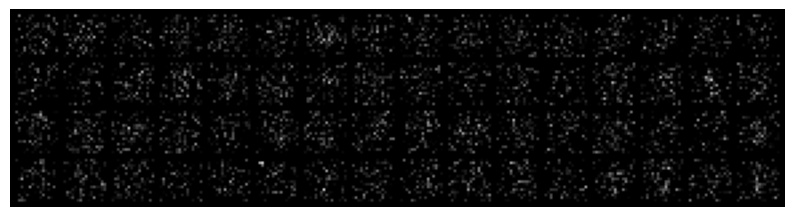

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


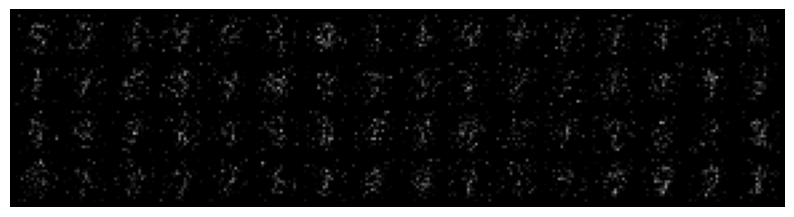

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


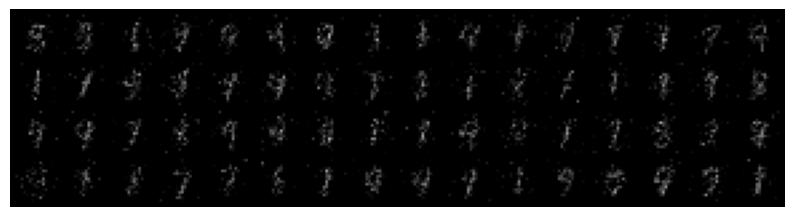

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


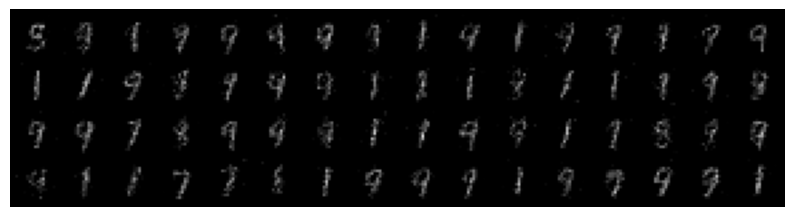

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


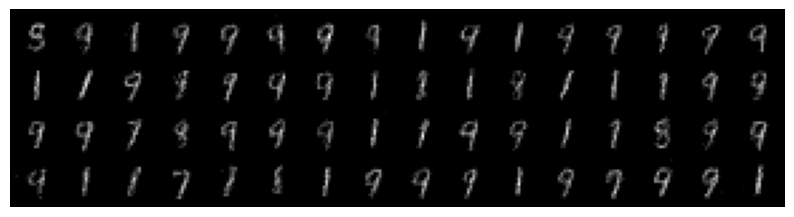

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


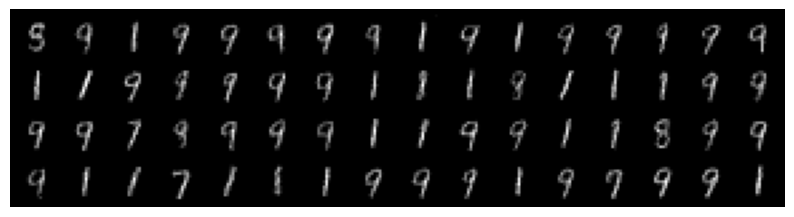

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


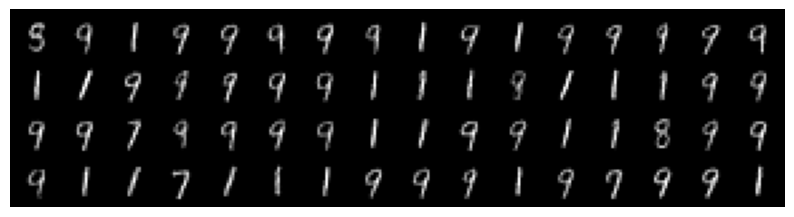

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


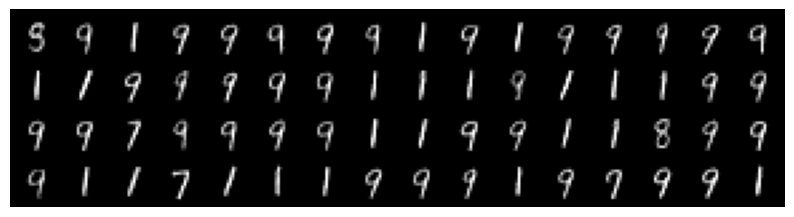

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


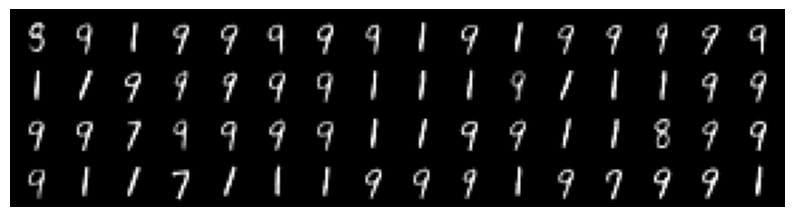

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


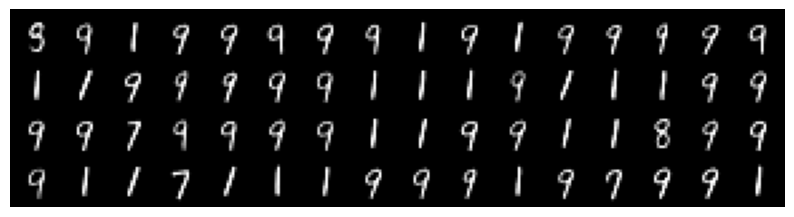

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


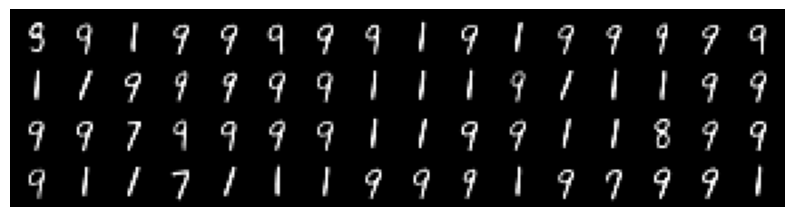

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


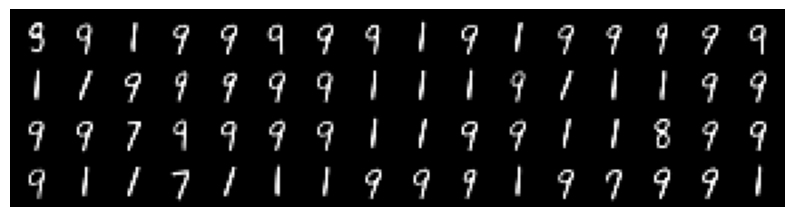

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


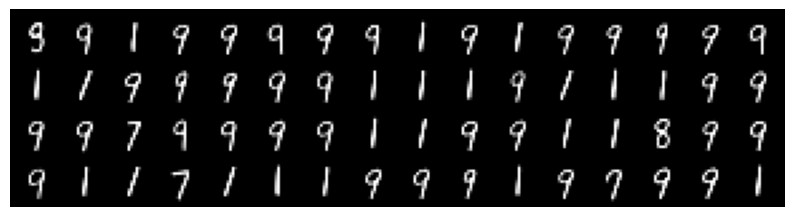

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


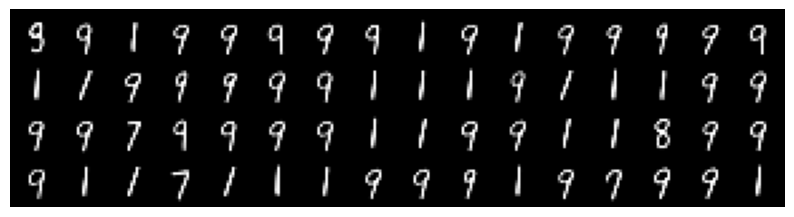

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


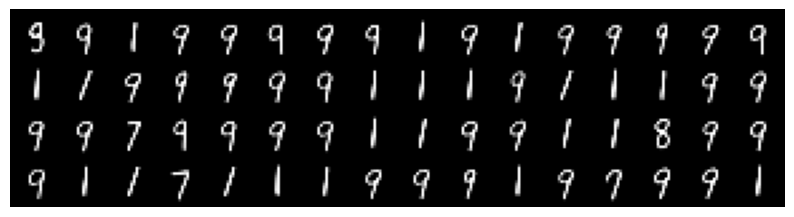

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


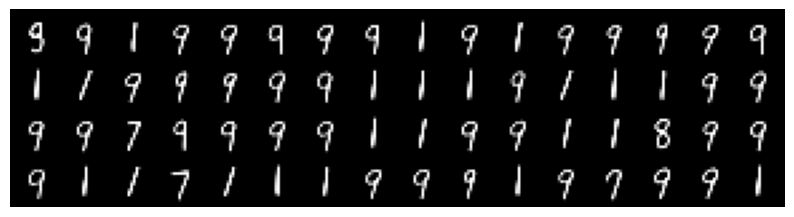

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


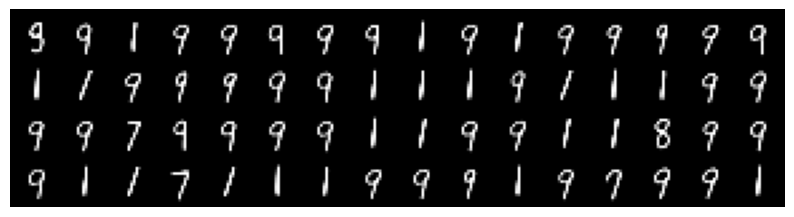

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


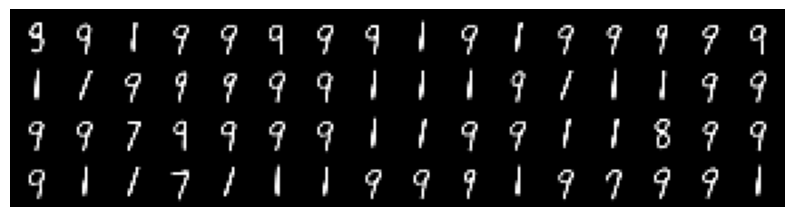

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


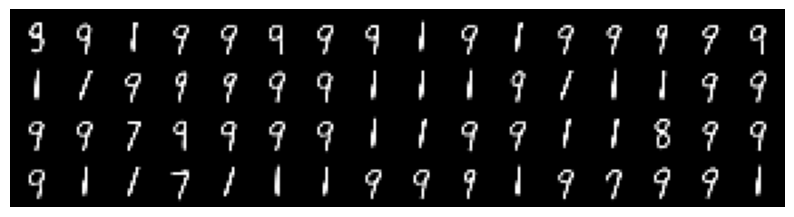

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


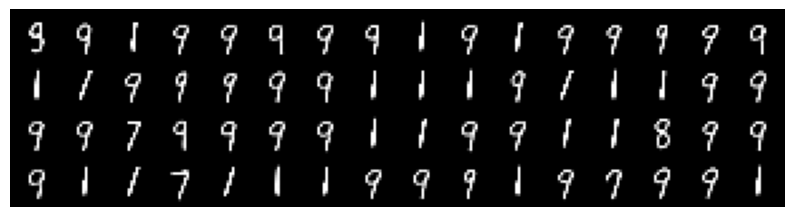

In [4]:
import torch
from tqdm.notebook import tqdm

# model.load_state_dict(torch.load("ddpm_minimal.ckpt"))
# model.to(device)

model.eval()

with torch.no_grad():

    # generate 64 samples
    xt = torch.randn(size=(64,1,IMG_SIZE,IMG_SIZE)).to(device)

    for t in tqdm(reversed(range(T)), desc="Sampling", total=T):

        z = torch.randn(size=xt.shape).to(device) if t>1 else torch.zeros_like(xt)
        
        sigma_t = (1-alpha_cumprod[t-1])/(1-alpha_cumprod[t]) * beta_schedule[t]
        t_tensor = torch.tensor([t]*xt.shape[0])

        xt = 1/torch.sqrt(alpha_schedule[t]) * (xt - (1-alpha_schedule[t])/torch.sqrt(1-alpha_cumprod[t]) * model(xt.to(device),t_tensor.to(device))) + sigma_t * z
        xt.clamp_(-1.,1.)

        if t%50 == 0:
            img = make_grid(xt, nrow=16)
            plt.figure(figsize=(10,4))
            plt.imshow(img.permute(1, 2, 0).cpu())
            plt.axis('off')
            plt.show()